<a href="https://colab.research.google.com/github/NOKOGIDO/Time-to-Event/blob/main/Modelos/DeepHit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DeepHit Método -  Single Event**
A continuación se muestra un ejemplo de cómo podemos entrenar un modelo **DeepHit** cuando solo tenemos un tipo de evento.

In [ ]:
!git clone https://github.com/havakv/pycox.git

fatal: destination path 'pycox' already exists and is not an empty directory.


In [ ]:
! pip install sklearn-pandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [ ]:
!pip install pycox

Pycox está construido sobre PyTorch y torchtuples, esto nos ayuda a entrenar redes neuronales con menos código repetitivo.

In [ ]:
import torch # For building the networks
import torchtuples as tt # Some useful functions

Importamos el dataset, el modelo DeepHitSingle y EvalSurv que simplifica el procedimiento de evaluación.

In [ ]:
from pycox.datasets import metabric
#from pycox.datasets import support
#from pycox.datasets import gbsg
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [ ]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(2587)
_ = torch.manual_seed(258)

# **Dataset**
Cargamos el dataset METABRIC (en este apartado podemos cambiar para seleccionar el dataset Rot. & GBSG o el dataset SUPPORT) y hacemos las particiones de entrenamiento, test y validación. La columna **duration** proporciona los tiempos observados y la columna **event** contiene indicadores de si la observación es un **evento** (1) o una **observación censurada** (0).

In [ ]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...
Done


In [ ]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
7,5.916774,5.289600,12.981733,6.009507,0.0,1.0,0.0,1.0,64.610001,143.000000,1
8,5.865741,6.738176,10.850687,5.596416,0.0,0.0,0.0,1.0,68.209999,150.600006,1
11,6.333529,5.170259,8.742507,6.500216,0.0,1.0,1.0,0.0,55.020000,141.166672,0


# **Transformación de Características**
Tenemos una serie de variables, además de las duraciones e indicadores de eventos.

Estandarizamos las variables numéricas y mantenemos las variables binarias. Las variables deben ser de tipo 'float32', ya que es necesario para el correcto funcionamiento de pytorch. Dependiendo del dataset seleccionado, debemos ajustar el número y tipo de variables, para su estandarización.

Utilizamos **sklearn_pandas.DataFrameMapper** para hacer un mapeo de características.

In [ ]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [ ]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# **Transformación de etiquetas**
Los métodos de supervivencia requieren transformaciones de etiquetas individuales, por lo que hemos incluido una **label_transform**, esta es solo una abreviatura de la clase **pycox.preprocessing.label_transforms.LabTransDiscreteTime.**

DeepHit es un método de tiempo discreto, por ello requiere definir intervalos de tiempo mediante discretización. Empleamos **num_durations** que define el tamaño de la cuadrícula de discretización (equidistante), lo que significa que nuestra red tendrá **num_durations** nodos de salida.

In [ ]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [ ]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

# **Neural net**
Creamos una MLP simple (Perceptrón Multicapa) con dos capas ocultas, activación ReLU, y **num_nodes** nodos de salida. También utilizamos **normalización batch** y **dropout** entre capas.

In [ ]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

# **Entrenamiento del modelo**
Para entrenar el modelo, es necesario definir un optimizador. En este caso se emplea **tt.optim** para la selección, ya que tiene alguna funcionalidad adicional. Se utiliza el optimizador **Adam**, pero en lugar de elegir una tasa de aprendizaje, usaremos el esquema propuesto por [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) para encontrar una tasa de aprendizaje adecuada con **model.lr_finder.** Puede consultar [esta publicación](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6?gi=df913b00c279) para obtener una explicación más detallada.

También configuramos el índice de duración que conecta los nodos de salida de la red con los tiempos de discretización. Esto sólo es útil para la predicción y no afecta el procedimiento de entrenamiento.

DeepHit tiene una pérdida que es una combinación de una probabilidad logarítmica negativa y una pérdida de clasificación. **Alpha** es un parámetro que controla la combinación lineal entre los dos y **sigma** es un parámetro utilizado por la pérdida de clasificación. **Alpha = 1** da una pérdida que solo contiene la probabilidad logarítmica negativa y **alpha = 0** da una pérdida de clasificación pura. Tenga en cuenta que esto es diferente al documento original.

In [ ]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

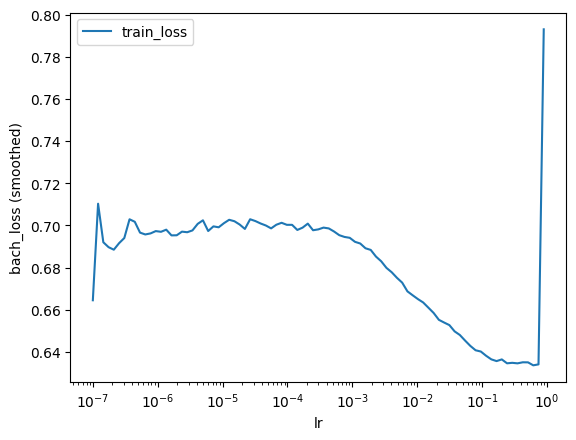

In [ ]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
_ = lr_finder.plot()

In [ ]:
lr_finder.get_best_lr()

0.0613590727341321

A menudo, esta tasa de aprendizaje es algo elevada, por lo que la configuramos manualmente en 0,01.

In [ ]:
model.optimizer.set_lr(0.01)

También se incluye **EarlyStoping** para detener el entrenamiento cuando la función de pérdida de validación deje de mejorar. Después del entrenamiento, se cargará el modelo con mejor rendimiento en términos de función de pérdida de la validación.

In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6693,	val_loss: 0.5756
1:	[0s / 0s],		train_loss: 0.5962,	val_loss: 0.5429
2:	[0s / 0s],		train_loss: 0.5652,	val_loss: 0.5279
3:	[0s / 0s],		train_loss: 0.5516,	val_loss: 0.5184
4:	[0s / 0s],		train_loss: 0.5432,	val_loss: 0.5163
5:	[0s / 0s],		train_loss: 0.5309,	val_loss: 0.5192
6:	[0s / 0s],		train_loss: 0.5244,	val_loss: 0.5187
7:	[0s / 0s],		train_loss: 0.5093,	val_loss: 0.5169
8:	[0s / 0s],		train_loss: 0.5107,	val_loss: 0.5160
9:	[0s / 0s],		train_loss: 0.5087,	val_loss: 0.5112
10:	[0s / 0s],		train_loss: 0.5084,	val_loss: 0.5085
11:	[0s / 0s],		train_loss: 0.4970,	val_loss: 0.5105
12:	[0s / 0s],		train_loss: 0.4971,	val_loss: 0.5095
13:	[0s / 1s],		train_loss: 0.4987,	val_loss: 0.5072
14:	[0s / 1s],		train_loss: 0.4986,	val_loss: 0.5027
15:	[0s / 1s],		train_loss: 0.4851,	val_loss: 0.5070
16:	[0s / 1s],		train_loss: 0.4905,	val_loss: 0.5078
17:	[0s / 1s],		train_loss: 0.4846,	val_loss: 0.5091
18:	[0s / 1s],		train_loss: 0.4926,	val_loss: 0.5044
19:

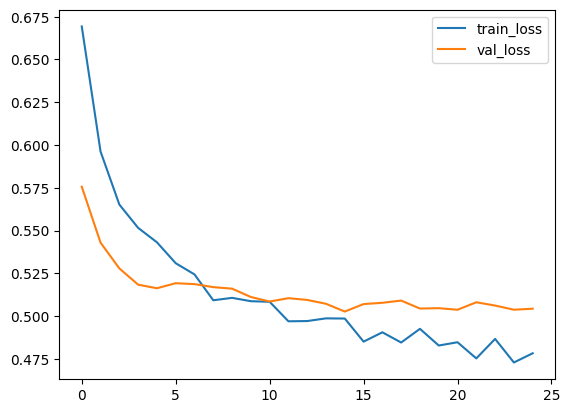

In [ ]:
_ = log.plot()

# **Predicción**
Para la evaluación, primero necesitamos obtener estimaciones de supervivencia para el conjunto de prueba. Esto se puede hacer con **model.predict_surv** que devuelve una serie de estimaciones de supervivencia, o con **model.predict_surv_df** que devuelve las estimaciones de supervivencia como un marco de datos.

In [ ]:
surv = model.predict_surv_df(x_test)

Podemos trazar las estimaciones de supervivencia para los primeros 5 individuos. Tenga en cuenta que la escala de tiempo es correcta porque hemos configurado **model.duration_index** para que sean los puntos de la cuadrícula. Sin embargo, solo hemos definido las estimaciones de supervivencia en los 10 tiempos en nuestra cuadrícula de discretización, por lo que las estimaciones de supervivencia son una función escalonada.

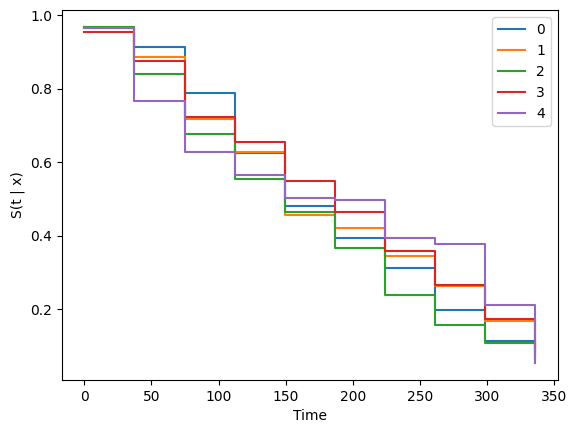

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Por lo tanto, a menudo es beneficioso interpolar las estimaciones de supervivencia, consulte [este artículo](https://arxiv.org/abs/1910.06724) para una discusión. La interpolación lineal (interpolación de densidad constante) se puede realizar con el método de **interpolate**. También debemos elegir con cuántos puntos queremos reemplazar cada punto de la cuadrícula. En este caso usaremos 10.

In [ ]:
surv = model.interpolate(10).predict_surv_df(x_test)

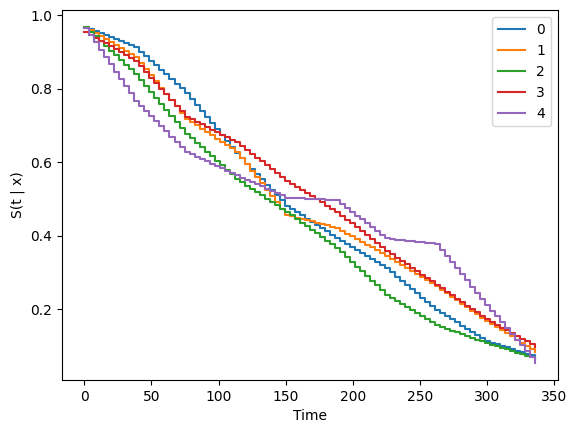

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# **Evaluación**
La clase **EvalSurv** contiene algunos criterios de evaluación útiles para la predicción del tiempo hasta el evento. Configuramos **censor_surv = 'km'** para indicar que queremos usar **Kaplan-Meier** para estimar la distribución de censura.

In [ ]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

/usr/local/lib/python3.10/dist-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


# **Concordancia**
Comenzamos con la concordancia **event-time** de [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [ ]:
ev.concordance_td('antolini')

0.6393497429896778

# **Brier Score**
Podemos trazar la puntuación de [IPCW Brier](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) para un conjunto de tiempos determinado. Aquí solo usamos 100 puntos de tiempo entre la duración mínima y máxima en el conjunto de prueba. Tenga en cuenta que la puntuación se vuelve inestable para los tiempos más altos. Por lo tanto, es común ignorar la parte más derecha del gráfico.

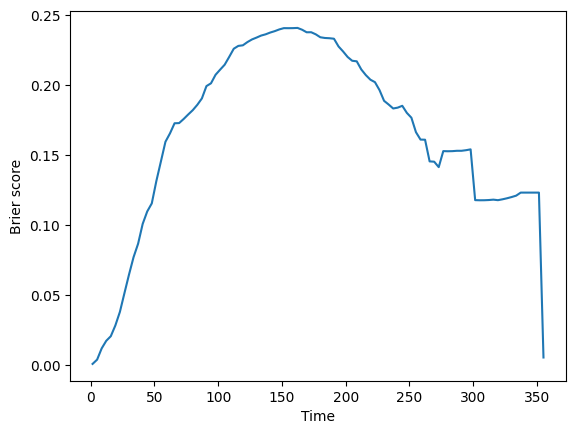

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

# **Negative binomial log-likelihood**
De manera similar, podemos trazar el [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

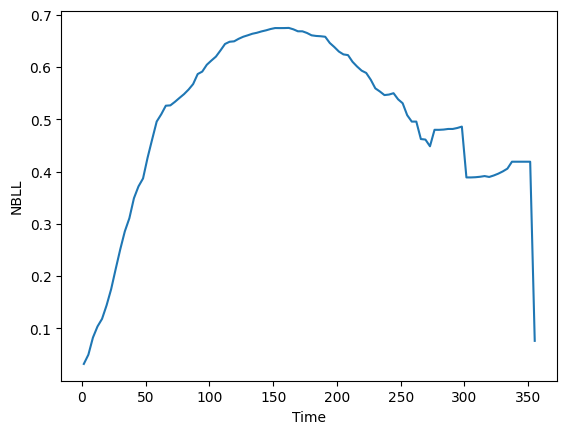

In [ ]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

# **Integrated scores**
Las dos puntuaciones anteriores dependientes del tiempo se pueden integrar a lo largo del tiempo para producir una puntuación única [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). En la práctica, esto se hace mediante integración numérica sobre una cuadrícula de tiempo definida.

In [ ]:
ev.integrated_brier_score(time_grid)

0.1664749310982349

In [ ]:

ev.integrated_nbll(time_grid)

0.5025377159746018